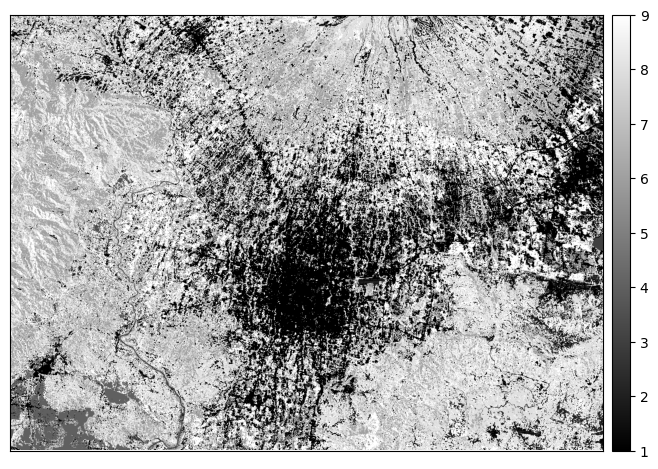

In [3]:
import tensorflow as tf                     # deep learning library. Tensors are just multi-dimensional arrays
import numpy as np                          # library to work with arrays
import matplotlib.pyplot as plt             # library for plotting
import pandas as pd                         # library for data manipulation
from ydata_profiling import ProfileReport   # library for data profiling
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report         # For evaluating the model
from sklearn.utils.class_weight import compute_class_weight                                         # For computing class weights
import matplotlib.pyplot as plt                                                                     # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
import geopandas as gpd
import os        
import sys
import matplotlib

# Parameters
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
LABEL = ['classvalue']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#006400', '#FF8C00']
CSV_PATH = 'carbon_stock_data/Yogyakarta_Carbon_Stock'
IMAGE_PATH = 'saved_data/Output_RF.tif'
# IMAGE_PATH = 'ndvi_data/Landsat_Jogja_2023_ALLFEATURES.tif'

# Load image
image = rasterio.open(IMAGE_PATH)
height = image.height
width = image.width
shape = (height, width)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Check the number of bands
num_bands = image_data.shape[0]

# If there are at least 3 bands, select the first 3 for RGB, otherwise use the available bands
if num_bands >= 3:
    # Select the first 3 bands (e.g., Red, Green, Blue)
    rgb_bands = image_data[:3]

    # Normalize the bands (0-1 range)
    rgb_bands = rgb_bands / np.max(rgb_bands)  # Normalize by the maximum value

    # Visualize the image as RGB
    ep.plot_rgb(rgb_bands, figsize=(8, 8), stretch=True)  # Stretch for better contrast
else:
    # If the image has only one band, visualize it as grayscale (without 'stretch' argument)
    ep.plot_bands(image_data[0], figsize=(8, 8), cmap="gray")

# Show the plot
plt.show()


I0000 00:00:1733840138.213295     913 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


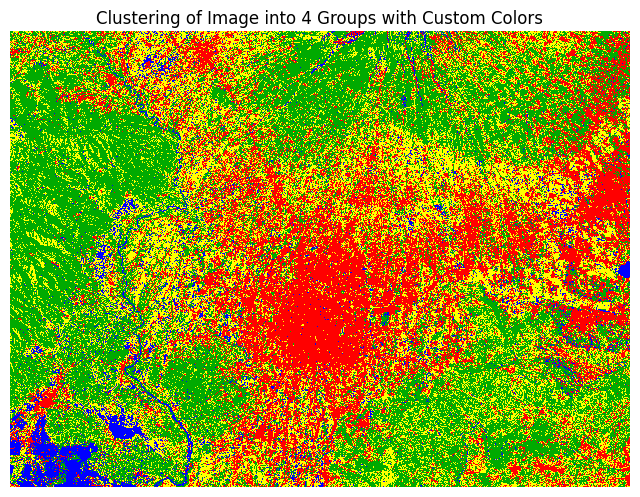

In [2]:
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Normalize the data (subtract mean, divide by standard deviation)
image_data_flat = tf.cast(image_data_flat, dtype=tf.float32)

# Manually normalize by subtracting mean and dividing by std deviation across bands
mean, variance = tf.nn.moments(image_data_flat, axes=[0])
stddev = tf.sqrt(variance)

# Normalize the data: (data - mean) / stddev
image_data_normalized = (image_data_flat - mean) / stddev

# Convert normalized data to numpy for sklearn compatibility
image_data_normalized_np = image_data_normalized.numpy()

# Function to get initial centroids based on class indices
def get_initial_centroids(X, class_indices):
    initial_centroids = []
    for idx in class_indices:
        initial_centroids.append(X[idx])
    return np.array(initial_centroids)

# Define class indices corresponding to classes 1, 4, 6, 8 (adjusted to 0-indexed)
class_indices = [0, 3, 5, 7]  # 0-indexed class positions corresponding to classes 1, 4, 6, 8

# Get the initial centroids based on the given class indices
initial_centroids = get_initial_centroids(image_data_normalized_np, class_indices)

# Initialize KMeans with custom centroids
kmeans = KMeans(n_clusters=4, init=initial_centroids, n_init=1)

# Fit the KMeans model
kmeans.fit(image_data_normalized_np)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Reshape the cluster labels back to the image dimensions
labels_reshaped = labels.reshape((height, width))

# Define custom color palette (4 colors for 4 clusters)
custom_palette = [
    '#00AA00',  # Green for Cluster 1
    '#FF0000',  # Red for Cluster 0
    '#FFFF00',   # Yellow for Cluster 3
    '#0000FF',  # Blue for Cluster 2
]

# Map each label to its corresponding color from the palette
cluster_colors = np.array([custom_palette[label] for label in labels])  # (n_samples,)
cluster_colors = cluster_colors.reshape((height, width))  # Reshape to image dimensions (height, width)

# Convert HEX colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Convert the color hex list to RGB
cluster_rgb = np.array([hex_to_rgb(c) for c in cluster_colors.flatten()])
cluster_rgb = cluster_rgb.reshape((height, width, 3))  # Reshape to image dimensions (height, width, 3)

# Visualize the clustered image with custom colors
plt.figure(figsize=(8, 8))
plt.imshow(cluster_rgb, interpolation='nearest')
plt.title("Clustering of Image into 4 Groups with Custom Colors")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()


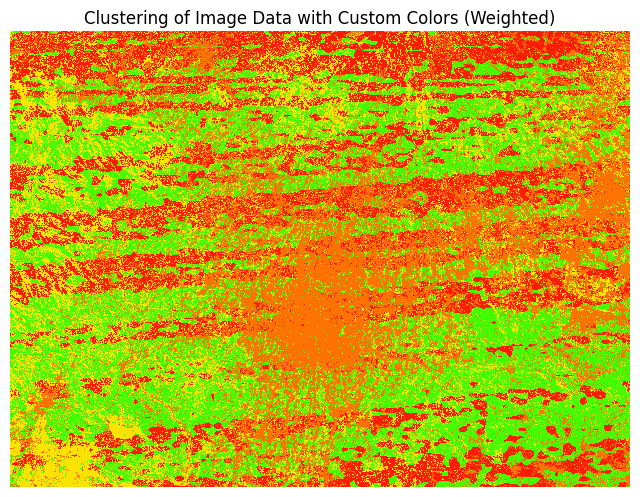

Clustered image saved to: clustered_image_output_weighted.tif


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Load CSV data
csv_path = 'carbon_stock_data/Semarang_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values

# Step 3: Reshape the carbon data to 2D
num_csv_rows = csv_features.shape[0]
csv_grid_height = int(np.sqrt(num_csv_rows))
csv_grid_width = num_csv_rows // csv_grid_height

# Adjust for any remaining rows
csv_features_2d = csv_features[:csv_grid_height * csv_grid_width].reshape(csv_grid_height, csv_grid_width, -1)

# Interpolate or resample the carbon grid to match the image dimensions
from scipy.ndimage import zoom

scale_height = height / csv_grid_height
scale_width = width / csv_grid_width
csv_features_resized = zoom(csv_features_2d, (scale_height, scale_width, 1), order=1)

# Step 4: Flatten the resized carbon data
csv_features_resized_flat = csv_features_resized.reshape((-1, csv_features_resized.shape[2]))

# Step 5: Normalize the data
scaler = StandardScaler()

# Normalize the image data (flattened)
image_data_normalized = scaler.fit_transform(image_data_flat)

# Normalize the resized CSV features
csv_features_normalized = scaler.fit_transform(csv_features_resized_flat)

# Step 6: Apply weights to the features
tif_weight = 5  # Give more importance to the TIF data
carbon_weight = 1  # Give less importance to the carbon data

weighted_image_data = image_data_normalized * tif_weight
weighted_carbon_data = csv_features_normalized * carbon_weight

# Combine the weighted features
combined_features = np.hstack((weighted_image_data, weighted_carbon_data))

# Step 7: Apply KMeans clustering using scikit-learn
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)

# Fit the model
kmeans.fit(combined_features)

# Get the cluster labels
labels = kmeans.labels_

# Step 8: Reshape the labels back to the image dimensions
labels_reshaped = labels.reshape(height, width)

# Step 9: Create a new TIFF image with cluster labels
output_path = 'clustered_image_output_weighted.tif'
profile = image.profile  # Use the same profile as the input image
profile.update(dtype=rasterio.uint8, count=1)  # Update profile for single-band integer data

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(labels_reshaped.astype(np.uint8), 1)

# Step 10: Visualize the clustered image with custom colors (optional)
custom_palette = [
    '#fc1c03',  # Red for Cluster 0
    '#fc7303',  # Orange for Cluster 1
    '#fce303',  # Yellow for Cluster 2
    '#45fc03'   # Green for Cluster 3
]

# Map each label to its corresponding color from the palette
cluster_colors = np.array([custom_palette[label] for label in labels])  # (n_samples,)
cluster_colors = cluster_colors.reshape(height, width)  # Reshape to image dimensions (height, width)

# Convert HEX colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Convert the color hex list to RGB
cluster_rgb = np.array([hex_to_rgb(c) for c in cluster_colors.flatten()])
cluster_rgb = cluster_rgb.reshape(height, width, 3)  # Reshape to image dimensions (height, width, 3)

# Step 11: Visualize the clustered image with custom colors
plt.figure(figsize=(8, 8))
plt.imshow(cluster_rgb, interpolation='nearest')
plt.title("Clustering of Image Data with Custom Colors (Weighted)")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

print(f"Clustered image saved to: {output_path}")


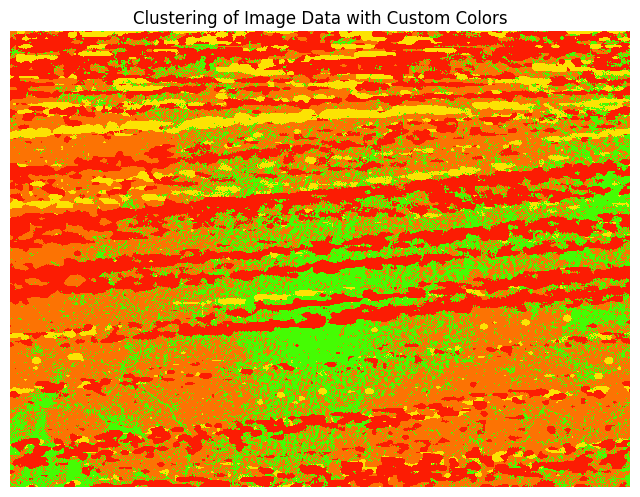

Clustered image saved to: saved_data/clustered_image_output.tif


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load the image using rasterio
image_path = 'saved_data/Output_RF.tif'
image = rasterio.open(image_path)

# Read the image data as a 3D array (bands, height, width)
image_data = image.read()

# Get the image dimensions (height, width)
height, width = image.height, image.width
num_bands = image_data.shape[0]

# Flatten the image data into 2D (height * width, num_bands)
image_data_flat = image_data.reshape((-1, num_bands))  # Shape: (height * width, num_bands)

# Step 2: Load CSV data
csv_path = 'carbon_stock_data/Yogyakarta_Carbon_Stock.csv'
csv_data = pd.read_csv(csv_path)

# Extract the features (replace with your actual feature columns)
csv_features = csv_data[['CA', 'CB', 'CS']].values

# Step 3: Reshape the carbon data to 2D
# Assume the carbon data should align with the image in some logical grid
num_csv_rows = csv_features.shape[0]
csv_grid_height = int(np.sqrt(num_csv_rows))
csv_grid_width = num_csv_rows // csv_grid_height

# Adjust for any remaining rows
csv_features_2d = csv_features[:csv_grid_height * csv_grid_width].reshape(csv_grid_height, csv_grid_width, -1)

# Interpolate or resample the carbon grid to match the image dimensions
from scipy.ndimage import zoom

scale_height = height / csv_grid_height
scale_width = width / csv_grid_width
csv_features_resized = zoom(csv_features_2d, (scale_height, scale_width, 1), order=1)

# Step 4: Flatten the resized carbon data
csv_features_resized_flat = csv_features_resized.reshape((-1, csv_features_resized.shape[2]))

# Step 5: Normalize the data
scaler = StandardScaler()

# Normalize the image data (flattened)
image_data_normalized = scaler.fit_transform(image_data_flat)

# Normalize the resized CSV features
csv_features_normalized = scaler.fit_transform(csv_features_resized_flat)

# Step 6: Combine the normalized image data and CSV features
combined_features = np.hstack((image_data_normalized, csv_features_normalized))

# Step 7: Apply KMeans clustering using scikit-learn
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)

# Fit the model
kmeans.fit(combined_features)

# Get the cluster labels
labels = kmeans.labels_

# Step 8: Reshape the labels back to the image dimensions
labels_reshaped = labels.reshape(height, width)

# Step 9: Create a new TIFF image with cluster labels
output_path = 'saved_data/clustered_image_output.tif'
profile = image.profile  # Use the same profile as the input image
profile.update(dtype=rasterio.uint8, count=1)  # Update profile for single-band integer data

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(labels_reshaped.astype(np.uint8), 1)

# Step 10: Visualize the clustered image with custom colors (optional)
custom_palette = [
    '#fc1c03',  # Red for Cluster 0
    '#fc7303',  # Orange for Cluster 1
    '#fce303',  # Yellow for Cluster 2
    '#45fc03'   # Green for Cluster 3
]

# Map each label to its corresponding color from the palette
cluster_colors = np.array([custom_palette[label] for label in labels])  # (n_samples,)
cluster_colors = cluster_colors.reshape(height, width)  # Reshape to image dimensions (height, width)

# Convert HEX colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Convert the color hex list to RGB
cluster_rgb = np.array([hex_to_rgb(c) for c in cluster_colors.flatten()])
cluster_rgb = cluster_rgb.reshape(height, width, 3)  # Reshape to image dimensions (height, width, 3)

# Step 11: Visualize the clustered image with custom colors
plt.figure(figsize=(8, 8))
plt.imshow(cluster_rgb, interpolation='nearest')
plt.title("Clustering of Image Data with Custom Colors")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

print(f"Clustered image saved to: {output_path}")
